In [ ]:
#!pip install

In [ ]:
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1Ux85UMh6Cs2Qy30Q7VgpV4gNAW_7vfkk" -O kaggle.json > /dev/null 2>&1

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle datasets download -d balraj98/clothing-coparsing-dataset

 99% 133M/134M [00:01<00:00, 150MB/s]
100% 134M/134M [00:01<00:00, 125MB/s]


In [ ]:

!unzip "clothing-coparsing-dataset.zip"
!rm -rf "clothing-coparsing-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images/1296.jpg         
  inflating: images/1297.jpg         
  inflating: images/1298.jpg         
  inflating: images/1299.jpg         
  inflating: images/1300.jpg         
  inflating: images/1301.jpg         
  inflating: images/1302.jpg         
  inflating: images/1303.jpg         
  inflating: images/1304.jpg         
  inflating: images/1305.jpg         
  inflating: images/1306.jpg         
  inflating: images/1307.jpg         
  inflating: images/1308.jpg         
  inflating: images/1309.jpg         
  inflating: images/1310.jpg         
  inflating: images/1311.jpg         
  inflating: images/1312.jpg         
  inflating: images/1313.jpg         
  inflating: images/1314.jpg         
  inflating: images/1315.jpg         
  inflating: images/1316.jpg         
  inflating: images/1317.jpg         
  inflating: images/1318.jpg         
  inflating: images/1319.jpg         
  inflating: images/1320.jpg         

In [ ]:

import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

In [ ]:
!pip install -U segmentation-models-pytorch

In [ ]:
DATA_DIR = '/content'
#create a path for it
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
#only consider these 3 columns
metadata_df = metadata_df[['image_path', 'label_type', 'label_path']]
#changes image path for each image to the new path defined here
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
#changes image path and creates a labels subdirectory
metadata_df['label_path'] = metadata_df['label_path'].apply(lambda lbl_pth: os.path.join(DATA_DIR, 'labels', lbl_pth))

# Select data subset with pixel-level annotations (ignoring image-level annotations)
# pixel level cause you need fine details when you're performing image segmentation. image-level ain't enuf
metadata_df = metadata_df[metadata_df['label_type']=='pixel-level']

# Shuffle DataFrame. frac=frac of dataset to shuffle. reset index after shuffle
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
print(metadata_df.head())
# Perform 95/5 split for train / val
# choosing randomly without specifiying random state will choose a different 5% of dataset each time
# so you need a random state. it's 42 here (hitchhiker's guide to the galaxy reference uwu)
# everytime random state is 42 it'll choose the same 5% of dataset everytime
valid_df = metadata_df.sample(frac=0.05, random_state=42)
# valid_df.index and not valid_df cause metadata_df and valid_df don't have same #rows
# drop only drops if there are same number of indices (rows)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

                 image_path   label_type  \
0  /content/images/0582.jpg  pixel-level   
1  /content/images/0398.jpg  pixel-level   
2  /content/images/0928.jpg  pixel-level   
3  /content/images/0201.jpg  pixel-level   
4  /content/images/0499.jpg  pixel-level   

                                          label_path  
0  /content/labels/pixel_level_labels_colored/058...  
1  /content/labels/pixel_level_labels_colored/039...  
2  /content/labels/pixel_level_labels_colored/092...  
3  /content/labels/pixel_level_labels_colored/020...  
4  /content/labels/pixel_level_labels_colored/049...  


(954, 50)

In [ ]:
# create a class_dict df from the csv file
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names frim the df and make a list
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value
class_names[0] = 'null'
# take r,g,b values from class_dict and create a list with each element having r,g,b values
class_rgb_values = class_dict[['r','g','b']].values.tolist()
# 1 class has a specific rgb value for it
print('All dataset classes and their corresponding RGB values in labels:')
print(f'\nThere are {len(class_names)} classes. Class Names: ', class_names)
print(f'\nThere are {len(class_rgb_values)} rgb values. Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:

There are 59 classes. Class Names:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

There are 59 rgb values. Class RGB values:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [

In [ ]:
# helper function for data visualization
def visualize(**images): #accepts variable #args which will be stored in a dict
    n_images = len(images)
    plt.figure(figsize=(20,8)) #width,height
    for idx, (name, image) in enumerate(images.items()): #get name,image from dict
        plt.subplot(1, n_images, idx + 1) #(rows,columns,position) idx+1 cause idx starts from 0
        plt.xticks([]); #removes values on the x axis
        plt.yticks([]) #removes values on the y axis
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20) #.title() makes it capital
        plt.imshow(image)
    plt.show()

In [ ]:
# Perform one hot encoding on label to convert these values to binary forma (if it belongs to that class or not)
def one_hot_encode(label, label_values): #rgb values of the image and of the 59 classes
    semantic_map = [] #one-hot-encoded-map
    for colour in label_values:
        equality = np.equal(label, colour) #array t if rgb values match with that class' values
        class_map = np.all(equality, axis = -1) #[0/1,0/1,0/1] chk if all 3 values are same
        semantic_map.append(class_map)
#each element,ie,pixel has 59 0/1 values showing if that pixel belongs to that class or not
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

In [ ]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [ ]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class ClothesDataset(torch.utils.data.Dataset):

    """Clothes Co-Parsing Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[i])[:,:,::-1]
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

    # Convert image and mask to NumPy arrays
        image = np.array(image)
        mask = np.array(mask)

        return image, mask


    def __len__(self):
        # return length of
        return len(self.image_paths)

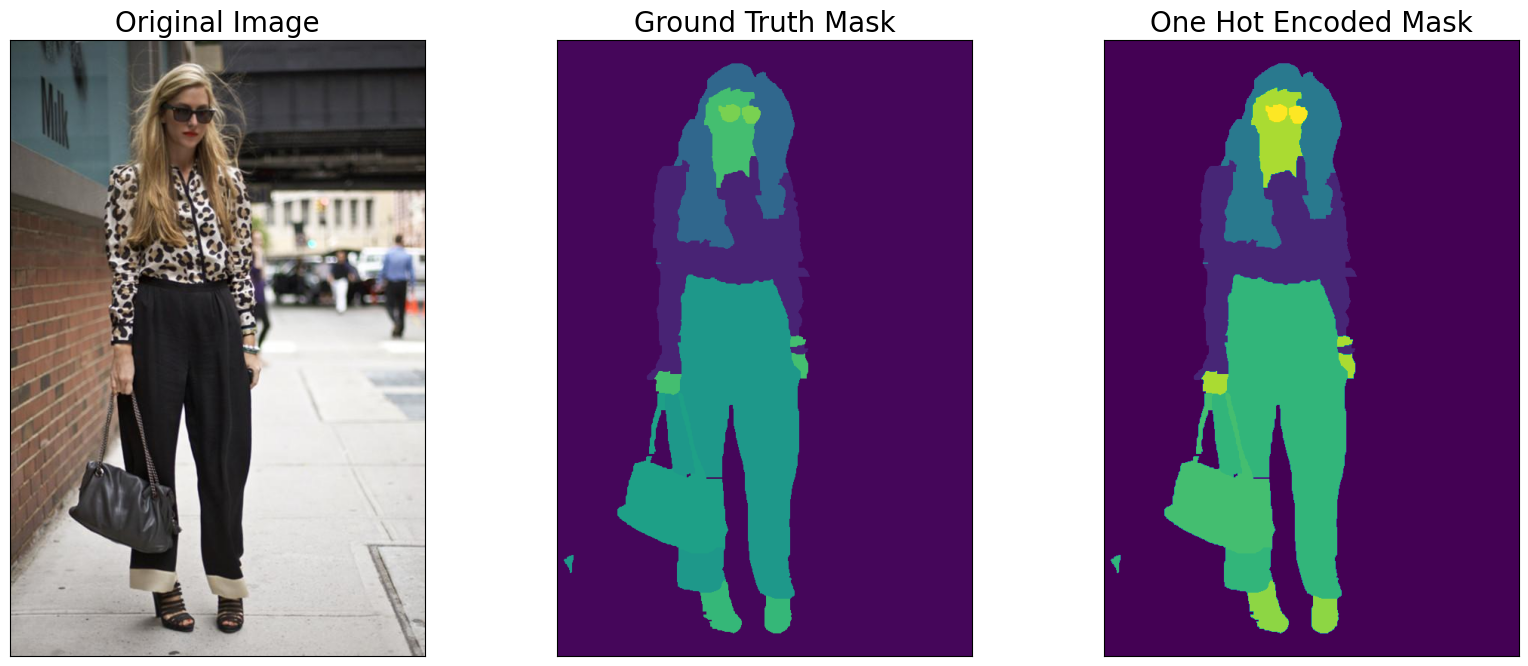

In [ ]:
dataset = ClothesDataset(train_df, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [
        # album.PadIfNeeded(min_height=896, min_width=576, always_apply=True, border_mode=0),
        album.ShiftScaleRotate(scale_limit=0.16, rotate_limit=30, shift_limit=0.16, p=0.8, border_mode=0),
        album.RandomCrop(height=384, width=384, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)

In [ ]:
def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 64
    test_transform = [
        album.PadIfNeeded(min_height=896, min_width=576, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

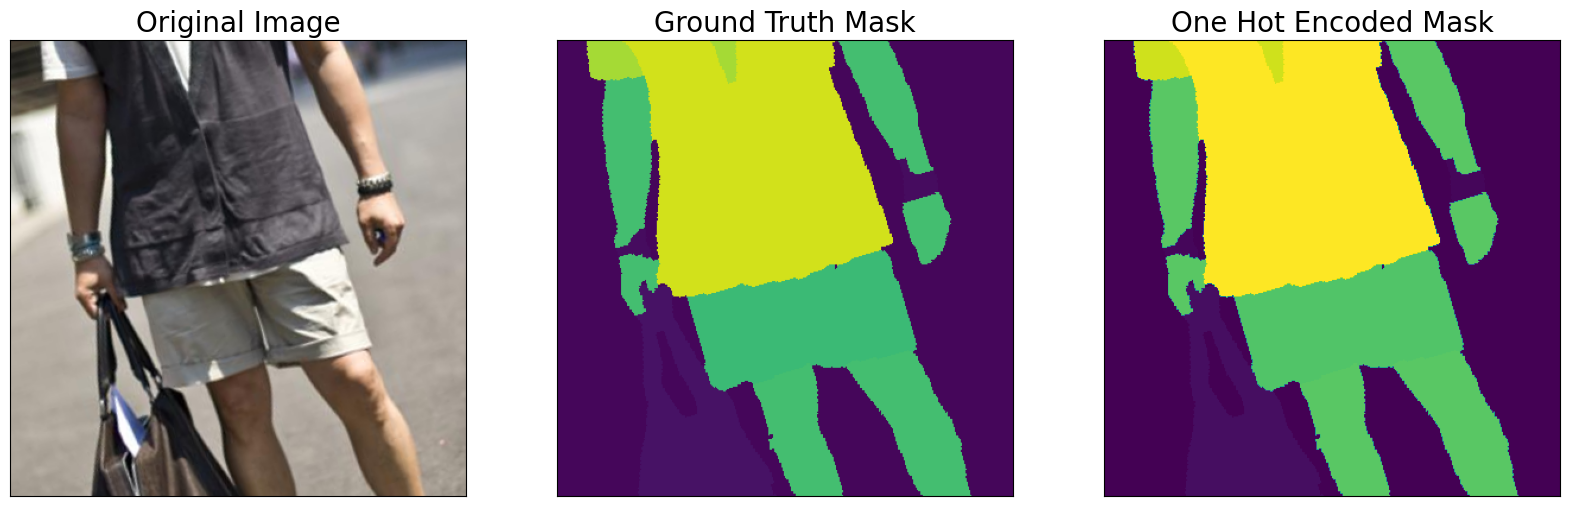

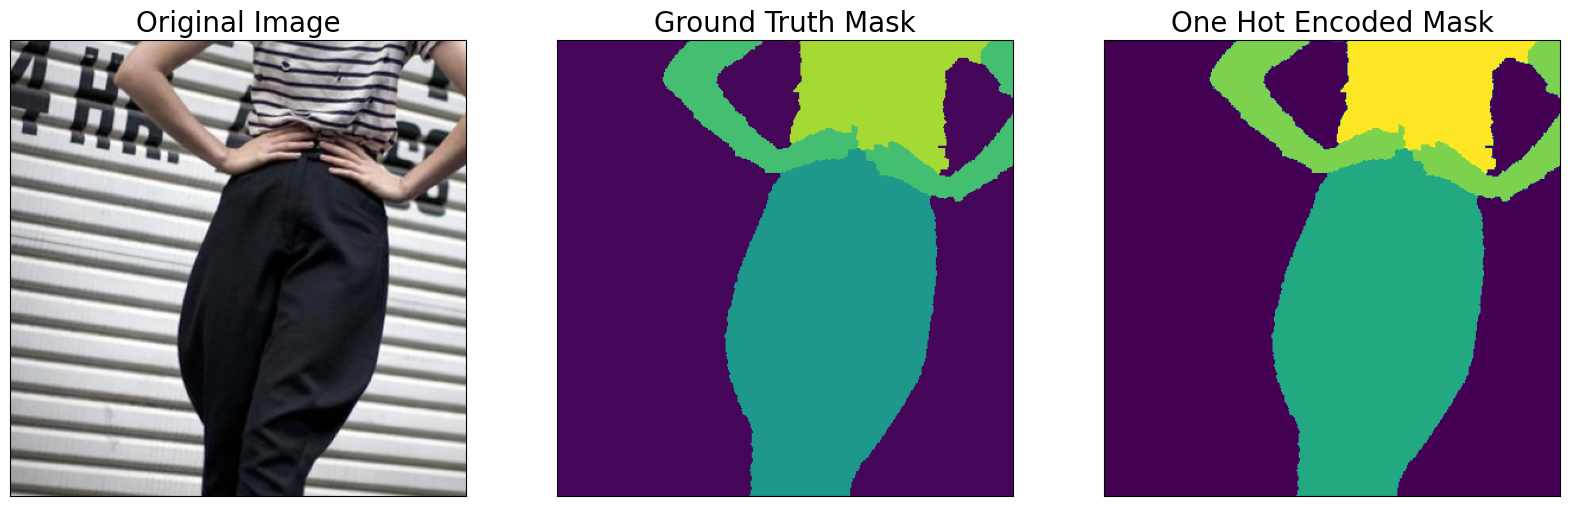

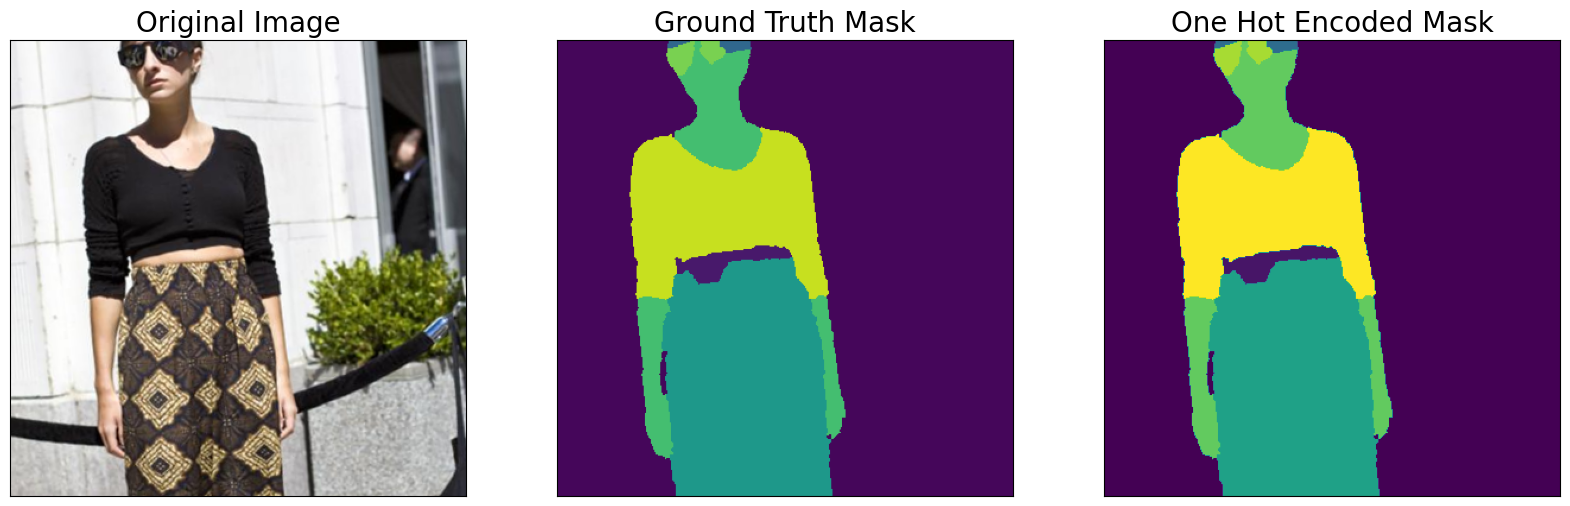

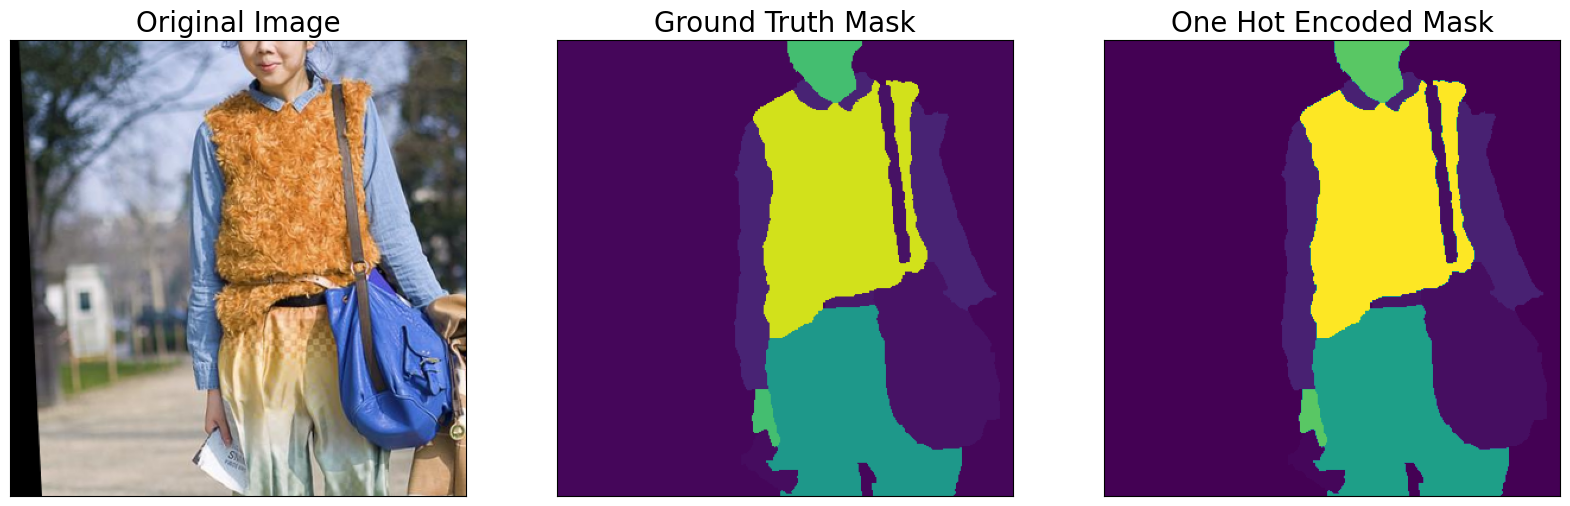

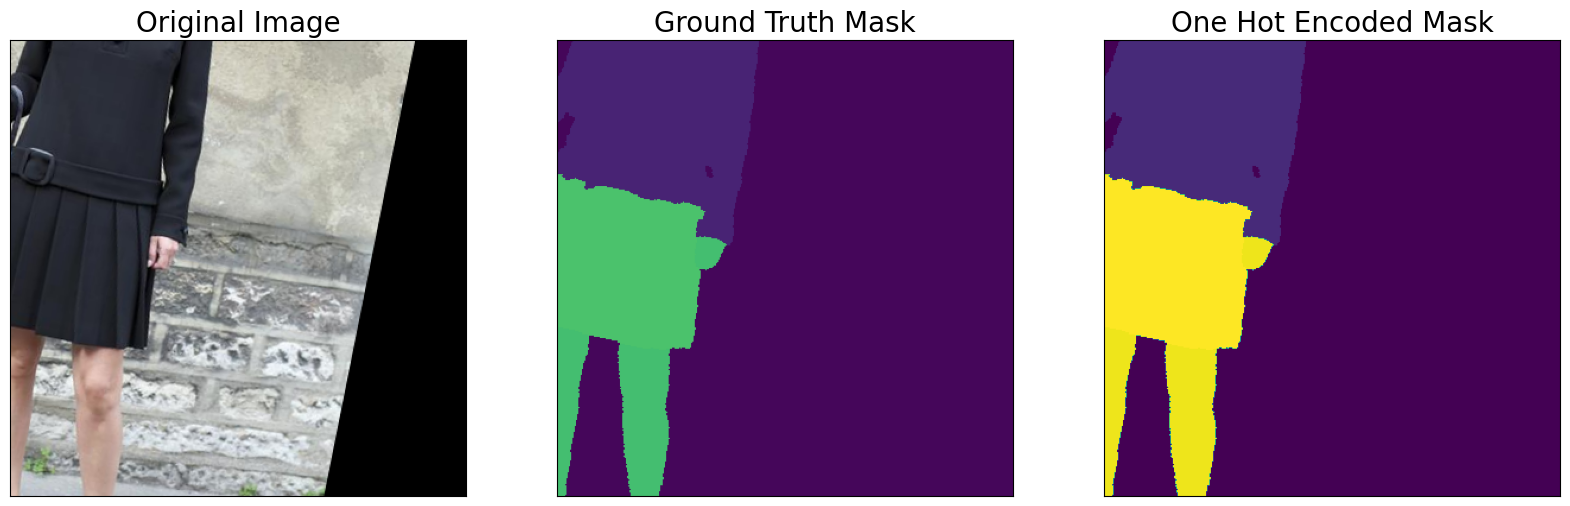

In [ ]:
augmented_dataset = ClothesDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(5):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.PAN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
for param in model.encoder.parameters():
    param.requires_grad = False
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [ ]:
train_dataset = ClothesDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

valid_dataset = ClothesDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
TRAINING = True
EPOCHS = 20
loss = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
criterion = smp.utils.losses.DiceLoss()
if os.path.exists('/content/pyramid-attention-network-pan-resnet50-pytorch/best_model.pth'):
    model = torch.load('/content/pyramid-attention-network-pan-resnet50-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, masks in loader:
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(loader)
    return epoch_loss

In [ ]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch: {epoch}')

        # Training
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # Validation
        model.eval()
        valid_logs = valid_epoch.run(valid_loader)

        print(f'Training Loss: {train_loss:.4f}, Validation IoU: {valid_logs["iou_score"]:.4f}')

        # Save the model if it performs better on validation
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model.state_dict(), './best_model.pth')
            print('Model saved!')


Epoch: 1
valid: 100%|██████████| 13/13 [01:39<00:00,  7.68s/it, dice_loss - 0.2993, iou_score - 0.6804]
Training Loss: 0.6134, Validation IoU: 0.6804
Model saved!

Epoch: 2


KeyboardInterrupt: ignored

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded PAN model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/pyramid-attention-network-pan-resnet50-pytorch/best_model.pth'):
    best_model = torch.load('/content/pyramid-attention-network-pan-resnet50-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded PAN model from a previous commit.')

Loaded PAN model from this run.


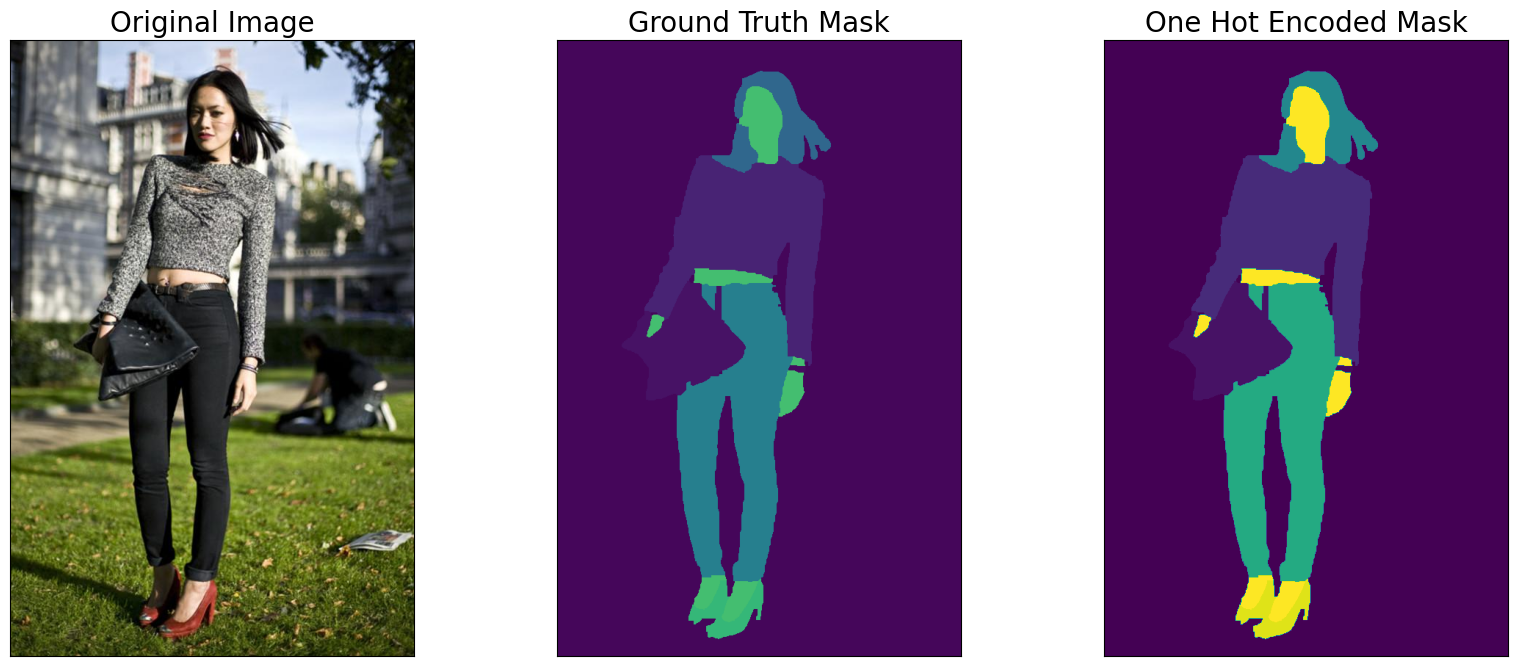

In [ ]:
test_dataset = ClothesDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = ClothesDataset(
    valid_df,
    class_rgb_values=class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
    )

TypeError: ignored

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 50/50 [01:56<00:00,  2.32s/it, dice_loss - 0.3118, iou_score - 0.6454]
Evaluation on Test Data: 
Mean IoU Score: 0.6454
Mean Dice Loss: 0.3118


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

""
